In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from pathlib import Path
from typing import List, Dict, Any, Set

In [2]:
def filter_corrupt_files(paths: List[Path]) -> (List[Dict[str, Any]], List[str]):
    """
    Filter out files that are not valid json files
    """
    data = {}
    corrupt_files = []
    for path in paths:
        try:
            with open(path, "r") as f:
                single_result = json.load(f)
            data[path.name] = single_result
        except json.decoder.JSONDecodeError:
            corrupt_files.append(path.name)
    return data, corrupt_files

In [3]:
# import Biomedical's data

paths = "../experiments/biomedical_projects_experiment/results_20240126/"

data_z, corrupt_z = filter_corrupt_files([Path(paths) / file for file in os.listdir(paths)])

print("Corrupt: ", corrupt_z)


Corrupt:  []


In [4]:

print(json.dumps({k: v for i, (k, v) in enumerate(data_z.items()) if i <5}, indent=4))

{
    "darkflow.json": {
        "metadata": {
            "project_name": "darkflow",
            "fawltydeps_version": "0.13.1.1",
            "repo_url": "https://:@github.com/thtrieu/darkflow.git",
            "creation_timestamp": "2024-01-29T10:28:48.244478"
        },
        "code_dirs": {
            "darkflow/dark": {
                "py": 6,
                "ipynb": 0,
                "total": 6
            },
            "darkflow/utils": {
                "py": 6,
                "ipynb": 0,
                "total": 6
            },
            "darkflow/net/yolo": {
                "py": 5,
                "ipynb": 0,
                "total": 5
            },
            "darkflow/net": {
                "py": 5,
                "ipynb": 0,
                "total": 5
            },
            "darkflow/net/ops": {
                "py": 4,
                "ipynb": 0,
                "total": 4
            },
            "darkflow": {
                "py": 4,
             

In [5]:
print(json.dumps({k: v["code_dirs"] for i, (k, v) in enumerate(data_z.items()) if i <5}, indent=4))

{
    "darkflow.json": {
        "darkflow/dark": {
            "py": 6,
            "ipynb": 0,
            "total": 6
        },
        "darkflow/utils": {
            "py": 6,
            "ipynb": 0,
            "total": 6
        },
        "darkflow/net/yolo": {
            "py": 5,
            "ipynb": 0,
            "total": 5
        },
        "darkflow/net": {
            "py": 5,
            "ipynb": 0,
            "total": 5
        },
        "darkflow/net/ops": {
            "py": 4,
            "ipynb": 0,
            "total": 4
        },
        "darkflow": {
            "py": 4,
            "ipynb": 0,
            "total": 4
        },
        "darkflow/net/yolov2": {
            "py": 4,
            "ipynb": 0,
            "total": 4
        },
        "darkflow/net/vanilla": {
            "py": 2,
            "ipynb": 0,
            "total": 2
        },
        ".": {
            "py": 1,
            "ipynb": 0,
            "total": 1
        },
        "darkflow/

In [6]:
def reduce_directory_levels(code_dirs: Dict[str, Any], deps_file: Dict[str, Any], level: int = 2) -> Dict[str, Any]:
    """
    Reduce the directory levels of code_dirs to `level` number of levels.
    Sums all the values of the same key.
    Also, remove setup.py files from the count
    """
    reduced_dirs = defaultdict(lambda: {"py": 0, "ipynb": 0, "total": 0})
    for k, v in code_dirs.items():
        reduced_dirs["/".join(k.split("/")[:level])]["py"] += v["py"]
        reduced_dirs["/".join(k.split("/")[:level])]["ipynb"] += v["ipynb"]
        reduced_dirs["/".join(k.split("/")[:level])]["total"] += v["total"]

    for k in deps_file:
        if k["parser_choice"] == "setup.py":
            setup_path = k["path"].split("/")[:-1]
            index = "/".join(["."] if not setup_path else setup_path[:level])
            reduced_dirs[index]["py"] -= 1
            reduced_dirs[index]["total"] -= 1

    return reduced_dirs


test = {        
    ".": {
            "py": 3,
            "ipynb": 0,
            "total": 3
        },
    "lib/pymice/_Python2": {
            "py": 3,
            "ipynb": 0,
            "total": 3
        },
        "lib/pymice/_Python3": {
            "py": 3,
            "ipynb": 0,
            "total": 3
        },
        "sphinx": {
            "py": 1,
            "ipynb": 0,
            "total": 1
        }}

rdl = reduce_directory_levels(test, {}, 2)
print(rdl)
rdl["lib/pymice"]


defaultdict(<function reduce_directory_levels.<locals>.<lambda> at 0x7f16456fba30>, {'.': {'py': 3, 'ipynb': 0, 'total': 3}, 'lib/pymice': {'py': 6, 'ipynb': 0, 'total': 6}, 'sphinx': {'py': 1, 'ipynb': 0, 'total': 1}})


{'py': 6, 'ipynb': 0, 'total': 6}

In [7]:
codedirs = defaultdict(dict)
for d in data_z.values():
    if d["code_dirs"]:
        #reduced_directories = reduce_directory_levels(d["code_dirs"],d["deps_file"], 2)       
        reduced_directories = reduce_directory_levels(d["code_dirs"],d["deps_file"], 1)       
        for folder, source_type_dict in reduced_directories.items():
            folder_cleaned = "/".join([v.replace(d["metadata"]["project_name"].lower(), "PROJECT_NAME") for v in folder.lower().split("/")])
            codedirs[d["metadata"]["project_name"]] |= {(folder_cleaned, "py"): source_type_dict["py"], (folder_cleaned,"ipynb"): source_type_dict["ipynb"]}
    else:
        codedirs[d["metadata"]["project_name"]] = {}

df_codedirs = pd.DataFrame.from_dict(codedirs, orient="index")

python_projects = set(df_codedirs.index)
print("Number of Python projects: ", len(python_projects))
print("Projects without any Python files")

Number of Python projects:  1473
Projects without any Python files


In [8]:
(df_codedirs.xs('py', level=1, axis=1) + df_codedirs.xs('ipynb', level=1, axis=1)).sum(axis=1).sort_values(ascending=False)

ray                 3526.0
osparc-simcore      2536.0
galaxy              1901.0
pandas              1507.0
nipype              1341.0
                     ...  
governance             1.0
Spikeling              1.0
mimic-website          1.0
CTC_RNAseq             1.0
biojava-tutorial       1.0
Length: 1473, dtype: float64

In [9]:
data_z["LeidenPDFhack.json"]

{'metadata': {'project_name': 'LeidenPDFhack',
  'fawltydeps_version': '0.13.1.1',
  'repo_url': 'https://:@github.com/rossmounce/LeidenPDFhack.git',
  'creation_timestamp': '2024-01-31T12:51:30.170923'},
 'code_dirs': {'.': {'py': 1, 'ipynb': 0, 'total': 1}},
 'deps_file': [],
 'imports': []}

### Are folders specialized - either for Python files or for notebooks?

In [10]:
# Are folders specialized - either for Python files or for notebooks?

# How many subcolumns nave both nonzero values, compared to one column having zero value?

codedirs_py = df_codedirs.xs('py', level=1, axis=1)
codedirs_ipynb = df_codedirs.xs('ipynb', level=1, axis=1)

print("Python files only")
display(codedirs_py.head())
print("Notebooks only")
display(codedirs_ipynb.head())

codedirs_sum = codedirs_py + codedirs_ipynb

print("Sum of Python files and notebooks")
display(codedirs_sum.head())

only_py_df = (codedirs_ipynb == 0) & (codedirs_py > 0)
only_ipynb_df = (codedirs_ipynb > 0) & (codedirs_py == 0)
both_df = (codedirs_ipynb > 0) & (codedirs_py > 0)

Python files only


,PROJECT_NAME,.,test,doc,bin,tests,biothings_client,docs,examples,scripts,...,packaging,rest_auth,cmp_to_immgen,buenrostro_c1,hek293_nih3t3_mix,other_cells_methods,cmp_to_buenrostro_c1,solutions,layer_runs2,20190909_figure4
darkflow,38.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
encode2bag,4.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
osmosis,100.0,0.0,NaN,13.0,6.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brian2genn,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yeadon,15.0,0.0,NaN,2.0,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Notebooks only


,PROJECT_NAME,.,test,doc,bin,tests,biothings_client,docs,examples,scripts,...,packaging,rest_auth,cmp_to_immgen,buenrostro_c1,hek293_nih3t3_mix,other_cells_methods,cmp_to_buenrostro_c1,solutions,layer_runs2,20190909_figure4
darkflow,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
encode2bag,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
osmosis,60.0,0.0,NaN,20.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brian2genn,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yeadon,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Sum of Python files and notebooks


,PROJECT_NAME,.,test,doc,bin,tests,biothings_client,docs,examples,scripts,...,packaging,rest_auth,cmp_to_immgen,buenrostro_c1,hek293_nih3t3_mix,other_cells_methods,cmp_to_buenrostro_c1,solutions,layer_runs2,20190909_figure4
darkflow,38.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
encode2bag,4.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
osmosis,160.0,0.0,NaN,33.0,6.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brian2genn,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yeadon,15.0,0.0,NaN,2.0,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



### How many projects have code directory with only Python files, only notebooks, or both?

In [11]:

def group_names(name):
    # Check if the name ends with 's'
    if name.endswith('s'):
        # If it does, return the singular form
        return name[:-1].lower()
    else:
        # If it doesn't, return the name as is
        return name.lower()


def group_codedirs(df, threshold=5):
    df = df.sum(axis=0)
    df = df.groupby(group_names).sum().sort_values(ascending=False)
    df = df[df >= threshold]
    return df

only_ipynb =  group_codedirs(only_ipynb_df)

only_py = group_codedirs(only_py_df)

both = group_codedirs(both_df)

len(only_ipynb), len(only_py), len(both)

(11, 24, 12)

### Directory structures grouping


In [12]:
print(df_codedirs.info())
df_codedirs.head()

depsfiles = defaultdict(list)
for d in data_z.values():
    if d["metadata"]["project_name"] in python_projects:
        if d["deps_file"]:
            depsfiles[d["metadata"]["project_name"]] = d["deps_file"]
        else:
            depsfiles[d["metadata"]["project_name"]] = {}

def check_dependencies_declaration(name: str) -> Set[str]:
    """
    Check the project named `name` declares dependencies and if yes, what types of parsers are used
    """
    return {dep["parser_choice"]for dep in depsfiles[name]}

<class 'pandas.core.frame.DataFrame'>
Index: 1473 entries, darkflow to nextmed
Columns: 2280 entries, ('PROJECT_NAME', 'py') to ('20190909_figure4', 'ipynb')
dtypes: float64(2280)
memory usage: 25.6+ MB
None



#### Python soup projects

266
PerCent of all projects: 18.06 %
Percent of soup projects that have declaration: 15.41 %


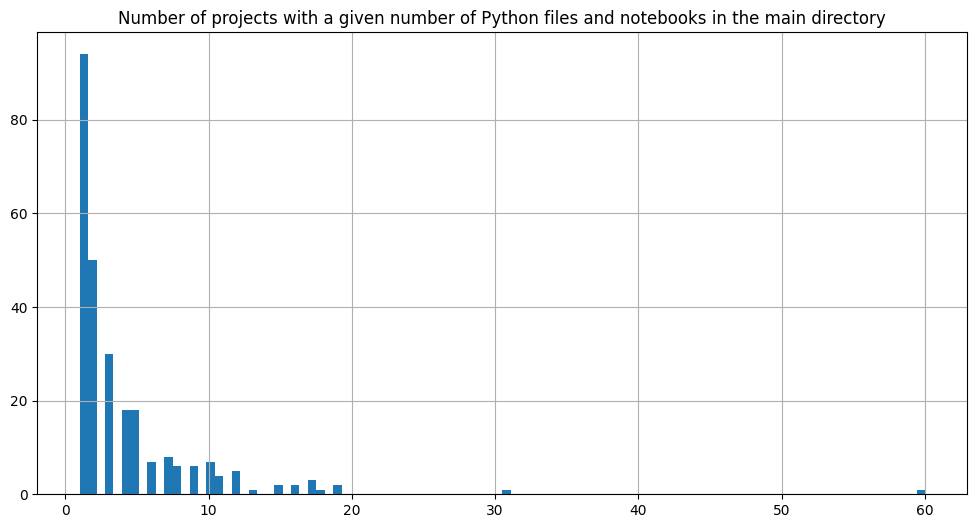

In [13]:
cond_soup = ((codedirs_ipynb['.'] > 0) | (codedirs_py['.'] > 0)) & (codedirs_py.drop('.', axis=1).sum(axis=1) == 0) & (codedirs_ipynb.drop('.', axis=1).sum(axis=1) == 0)
soup_projects = (codedirs_py + codedirs_ipynb)[cond_soup].dropna(axis=1, how='all').sort_values(by='.', ascending=False)
soup_projects.hist(bins=100, figsize=(12, 6))
plt.title("Number of projects with a given number of Python files and notebooks in the main directory")
soup_projects_index = soup_projects.index
print(len(soup_projects))
print(f"PerCent of all projects: {round(len(soup_projects) / len(df_codedirs) * 100, 2)} %")

deps_declaration_soup = [len(check_dependencies_declaration(name))>0 for name in soup_projects_index]
print(f"Percent of soup projects that have declaration: {round(sum(deps_declaration_soup) / len(soup_projects) * 100, 2)} %")



In [14]:
index_soup_2 = soup_projects[soup_projects["."] <=2].index
df_codedirs.loc[index_soup_2]

PROJECT_NAME          .       test        \
                                              py ipynb   py ipynb   py ipynb   
annotations                                  NaN   NaN  2.0   0.0  NaN   NaN   
pdb_structure_quality                        NaN   NaN  0.0   2.0  NaN   NaN   
mining-discovery-with-deep-learning          NaN   NaN  0.0   2.0  NaN   NaN   
Nematostella-viruses-project                 NaN   NaN  0.0   2.0  NaN   NaN   
fatdistnGWAS                                 NaN   NaN  2.0   0.0  NaN   NaN   
...                                          ...   ...  ...   ...  ...   ...   
papers-methodology                           NaN   NaN  0.0   1.0  NaN   NaN   
LeidenPDFhack                                NaN   NaN  1.0   0.0  NaN   NaN   
cg_pip2_topology_files                       NaN   NaN  1.0   0.0  NaN   NaN   
tutorial_orthology                           NaN   NaN  0.0   1.0  NaN   NaN   
OmaDB                                        NaN   NaN  0.0   1.0  NaN   NaN   

                                    doc       bin        ...  \
                                     py ipynb  py ipynb  ...   
annotations                         NaN   NaN NaN   NaN  ...   
pdb_structure_quality               NaN   NaN NaN   NaN  ...   
mining-discovery-with-deep-learning NaN   NaN NaN   NaN  ...   
Nematostella-viruses-project        NaN   NaN NaN   NaN  ...   
fatdistnGWAS                        NaN   NaN NaN   NaN  ...   
...                                  ..   ...  ..   ...  ...   
papers-methodology                  NaN   NaN NaN   NaN  ...   
LeidenPDFhack                       NaN   NaN NaN   NaN  ...   
cg_pip2_topology_files              NaN   NaN NaN   NaN  ...   
tutorial_orthology                  NaN   NaN NaN   NaN  ...   
OmaDB                               NaN   NaN NaN   NaN  ...   

                                    other_cells_methods        \
                                                     py ipynb   
annotations                                         NaN   NaN   
pdb_structure_quality                               NaN   NaN   
mining-discovery-with-deep-learning                 NaN   NaN   
Nematostella-viruses-project                        NaN   NaN   
fatdistnGWAS                                        NaN   NaN   
...                                                 ...   ...   
papers-methodology                                  NaN   NaN   
LeidenPDFhack                                       NaN   NaN   
cg_pip2_topology_files                              NaN   NaN   
tutorial_orthology                                  NaN   NaN   
OmaDB                                               NaN   NaN   

                                    cmp_to_buenrostro_c1       solutions  \
                                                      py ipynb        py   
annotations                                          NaN   NaN       NaN   
pdb_structure_quality                                NaN   NaN       NaN   
mining-discovery-with-deep-learning                  NaN   NaN       NaN   
Nematostella-viruses-project                         NaN   NaN       NaN   
fatdistnGWAS                                         NaN   NaN       NaN   
...                                                  ...   ...       ...   
papers-methodology                                   NaN   NaN       NaN   
LeidenPDFhack                                        NaN   NaN       NaN   
cg_pip2_topology_files                               NaN   NaN       NaN   
tutorial_orthology                                   NaN   NaN       NaN   
OmaDB                                                NaN   NaN       NaN   

                                          layer_runs2       20190909_figure4  \
                                    ipynb          py ipynb               py   
annotations                           NaN         NaN   NaN              NaN   
pdb_structure_quality                 NaN         NaN   NaN              NaN   
mining-

#### Projects with the same main folder as the project name

In [15]:

cond_same_name = ((codedirs_ipynb['PROJECT_NAME'] > 0) | (codedirs_py['PROJECT_NAME'] > 0)) 
same_name_projects = (codedirs_py + codedirs_ipynb)[cond_same_name].dropna(axis=1, how='all')
same_name_projects_index = same_name_projects.index
print(len(same_name_projects))

deps_declaration_same_name = [len(check_dependencies_declaration(name))>0 for name in same_name_projects_index]
print(f"PerCent of all projects: {round(len(same_name_projects) / len(df_codedirs) * 100, 2)} %")
print(f"Percent of soup projects that have declaration: {round(sum(deps_declaration_same_name) / len(same_name_projects) * 100, 2)} %")



374
PerCent of all projects: 25.39 %
Percent of soup projects that have declaration: 95.72 %


#### Projects with `src` folder

In [20]:
same_name_projects[same_name_projects['src'] >0]

,PROJECT_NAME,.,test,doc,bin,tests,docs,examples,scripts,docs_sphinx,...,doc_template,testnotebooks,demonotebooks,old_folders,test_performance,test_nondeterministic,qt_app,plate_templates,kg,gource
PyFBA,98.0,0.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
[x for x in codedirs_py.columns if "src" in x]

['src',
 'src_python',
 'PROJECT_NAME_src',
 'docsrc',
 'doc-src',
 'src visualization']

In [34]:
cond_src = ((codedirs_ipynb['src'] > 0) | (codedirs_ipynb['src_python'] > 0) | (codedirs_ipynb['PROJECT_NAME_src'] > 0) | (codedirs_py['src'] > 0) | (codedirs_py['src_python'] > 0) | (codedirs_py['PROJECT_NAME_src'] > 0)) 
src_projects = (codedirs_py + codedirs_ipynb)[cond_src].dropna(axis=1, how='all')
src_projects_index = src_projects.index
print(len(src_projects))

deps_declaration_src = [len(check_dependencies_declaration(name))>0 for name in src_projects_index]
print(f"PerCent of all projects: {round(len(src_projects) / len(df_codedirs) * 100, 2)} %")
print(f"Percent of soup projects that have declaration: {round(sum(deps_declaration_src) / len(src_projects) * 100, 2)} %")


115
PerCent of all projects: 7.81 %
Percent of soup projects that have declaration: 67.83 %


In [55]:
src_projects[src_projects["scripts"]>0]

,PROJECT_NAME,.,test,doc,bin,tests,docs,examples,scripts,src,...,example-plugin,ipnotebooks,PROJECT_NAME_docs,cloud,contributions,eda,xpsdoniachs,notebooks_manuscript,notebooks_tutorial,logo
epivizFileServer,NaN,0.0,NaN,NaN,NaN,6.0,1.0,NaN,5.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bokeh,NaN,0.0,NaN,NaN,NaN,337.0,37.0,517.0,5.0,349.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
imfusion,NaN,0.0,NaN,NaN,NaN,20.0,1.0,NaN,1.0,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
toil-vg,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bedtools2,NaN,NaN,4.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HipSTR,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,4.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pytest,NaN,NaN,NaN,23.0,NaN,NaN,NaN,NaN,5.0,69.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
black,NaN,NaN,NaN,NaN,NaN,207.0,1.0,NaN,9.0,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
instamatic,NaN,NaN,NaN,NaN,NaN,7.0,4.0,NaN,11.0,134.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
flapjack,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Project with `scripts` folder 

In [40]:
rest_projects = (codedirs_py + codedirs_ipynb)[~cond_src][~cond_same_name][~cond_soup]

/tmp/ipykernel_147670/1894459513.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rest_projects = (codedirs_py + codedirs_ipynb)[~cond_src][~cond_same_name][~cond_soup]
/tmp/ipykernel_147670/1894459513.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rest_projects = (codedirs_py + codedirs_ipynb)[~cond_src][~cond_same_name][~cond_soup]


In [66]:
len(rest_projects)

719

In [65]:
rest_projects.count(axis=0).sort_values()

src_python        0
util-scripts      0
nbs               0
dev_nbs           0
docs_sphinx       0
               ... 
tests            63
docs             86
notebooks        88
scripts          90
.               303
Length: 1140, dtype: int64

In [67]:
cond_scripts = ((codedirs_ipynb['scripts'] > 0) | (codedirs_py['scripts'] > 0)) 
scripts_projects = (codedirs_py + codedirs_ipynb)[cond_scripts].dropna(axis=1, how='all')
scripts_projects_index = scripts_projects.index
print(len(scripts_projects))

deps_declaration_scripts = [len(check_dependencies_declaration(name))>0 for name in scripts_projects_index]
print(f"PerCent of all projects: {round(len(scripts_projects) / len(df_codedirs) * 100, 2)} %")
print(f"Percent of scripts projects that have declaration: {round(sum(deps_declaration_scripts) / len(scripts_projects) * 100, 2)} %")


135
PerCent of all projects: 9.16 %
Percent of scripts projects that have declaration: 56.3 %


In [68]:
# Check how many of them have `tests` directory

tested_same_name_projects = same_name_projects[((same_name_projects['tests'] > 0) | (same_name_projects['test'] > 0) | (same_name_projects['testing'] > 0))]  

print(f"Percent of tested projects 'same name' {round(len(tested_same_name_projects) / len(same_name_projects) * 100, 2)} %")

Percent of tested projects 'same name' 37.43 %


In [69]:

# some of those libs are notebook-heavy
same_name_notebooks_vs_py = pd.DataFrame.from_dict({"ipynb": codedirs_ipynb.loc[same_name_projects_index].sum(axis=1),
              "py":codedirs_py.loc[same_name_projects_index].sum(axis=1)}).sort_values(by="ipynb", ascending=False)
same_name_notebooks_vs_py["% notebooks"] = same_name_notebooks_vs_py["ipynb"] / same_name_notebooks_vs_py.sum(axis=1)
same_name_notebooks_vs_py.sort_values(by="% notebooks", ascending=False).head(20)


,ipynb,py,% notebooks
MotionClouds,17.0,3.0,0.850000
pyMolNetEnhancer,6.0,2.0,0.750000
bbknn,7.0,3.0,0.700000
CosinorPy,12.0,6.0,0.666667
visJS2jupyter,7.0,4.0,0.636364
MuMoT,17.0,10.0,0.629630
ipyrad,88.0,53.0,0.624113
syba,3.0,2.0,0.600000
misas,11.0,8.0,0.578947
abitutorials,25.0,20.0,0.555556


#### Notebook-heavy
Not included prebviously, more than 80% are notebooks


In [70]:
cond_notebooks_heavy = (codedirs_ipynb.div(codedirs_sum).fillna(0)["notebooks"] > 0.8 ) | (codedirs_py.div(codedirs_sum).fillna(0)["notebook"] > 0.8)
notebooks_heavy_projects = (codedirs_py + codedirs_ipynb)[cond_notebooks_heavy].dropna(axis=1, how='all')
notebooks_heavy_project_index = notebooks_heavy_projects.index
print(len(notebooks_heavy_projects))
print(f"PerCent of all projects: {round(len(notebooks_heavy_projects) / len(df_codedirs) * 100, 2)} %")

120
PerCent of all projects: 8.15 %


#### CATEGORY???

In [73]:
# take only those projects that are not categorised as same name or soup from df_codedirs


left = df_codedirs.drop(set(soup_projects_index) | set(same_name_projects_index)).dropna(axis=1, how='all')

cond_src = ((codedirs_ipynb['src'] > 0) | (codedirs_py['src'] > 0)) 
src_projects = (codedirs_py + codedirs_ipynb)[cond_src].dropna(axis=1, how='all')
src_project_index = src_projects.index
print(len(src_projects))
print(f"PerCent of all projects: {round(len(src_projects) / len(df_codedirs) * 100, 2)} %")

113
PerCent of all projects: 7.67 %


In [75]:
df_same_name_project = df_codedirs.loc[same_name_projects_index].dropna(axis=1, how='all')
df_same_name_project[df_same_name_project>15].dropna(axis=1, how='all')

PROJECT_NAME       test doc       tests       docs       examples  \
                     py ipynb   py  py ipynb    py ipynb   py ipynb       py   
darkflow           38.0   NaN  NaN NaN   NaN   NaN   NaN  NaN   NaN      NaN   
encode2bag          NaN   NaN  NaN NaN   NaN   NaN   NaN  NaN   NaN      NaN   
osmosis           100.0  60.0  NaN NaN  20.0   NaN   NaN  NaN   NaN      NaN   
brian2genn          NaN   NaN  NaN NaN   NaN   NaN   NaN  NaN   NaN      NaN   
yeadon              NaN   NaN  NaN NaN   NaN   NaN   NaN  NaN   NaN      NaN   
...                 ...   ...  ...  ..   ...   ...   ...  ...   ...      ...   
alleninf            NaN   NaN  NaN NaN   NaN   NaN   NaN  NaN   NaN      NaN   
intern             91.0   NaN  NaN NaN   NaN   NaN   NaN  NaN   NaN     18.0   
visbrain          188.0   NaN  NaN NaN   NaN   NaN   NaN  NaN   NaN     52.0   
gseapy              NaN   NaN  NaN NaN   NaN   NaN   NaN  NaN   NaN      NaN   
medaka             41.0   NaN  NaN NaN   NaN   NaN   NaN  NaN   NaN      NaN   

            ... experimental guides third_party scraps _stale ui-tests batch  \
            ...           py     py          py     py     py    ipynb    py   
darkflow    ...          NaN    NaN         NaN    NaN    NaN      NaN   NaN   
encode2bag  ...          NaN    NaN         NaN    NaN    NaN      NaN   NaN   
osmosis     ...          NaN    NaN         NaN    NaN    NaN      NaN   NaN   
brian2genn  ...          NaN    NaN         NaN    NaN    NaN      NaN   NaN   
yeadon      ...          NaN    NaN         NaN    NaN    NaN      NaN   NaN   
...         ...          ...    ...         ...    ...    ...      ...   ...   
alleninf    ...          NaN    NaN         NaN    NaN    NaN      NaN   NaN   
intern      ...          NaN    NaN         NaN    NaN    NaN      NaN   NaN   
visbrain    ...          NaN    NaN         NaN    NaN    NaN      NaN   NaN   
gseapy      ...          NaN    NaN         NaN    NaN    NaN      NaN   NaN   
medaka      ...          NaN    NaN         NaN    NaN    NaN      NaN   NaN   

           old_folders       qt_app  
                    py ipynb     py  
darkflow           NaN   NaN    NaN  
encode2bag         NaN   NaN    NaN  
osmosis            NaN   NaN    NaN  
brian2genn         NaN   NaN    NaN  
yeadon             NaN   NaN    NaN  
...                ...   ...    ...  
alleninf           NaN   NaN    NaN  
intern             NaN   NaN    NaN  
visbrain           NaN   NaN    NaN  
gseapy             NaN   NaN    NaN  
medaka             NaN   NaN    NaN  

[374 rows x 51 columns]

In [76]:
df_codedirs.loc["openprescribing"].dropna()

print(json.dumps(data_z["qiime.json"], indent=4))

{
    "metadata": {
        "project_name": "qiime",
        "fawltydeps_version": "0.13.1.1",
        "repo_url": "https://:@github.com/biocore/qiime.git",
        "creation_timestamp": "2024-01-29T13:01:22.250567"
    },
    "code_dirs": {
        "scripts": {
            "py": 155,
            "ipynb": 0,
            "total": 155
        },
        "qiime": {
            "py": 89,
            "ipynb": 0,
            "total": 89
        },
        "tests": {
            "py": 88,
            "ipynb": 0,
            "total": 88
        },
        "qiime/parallel": {
            "py": 13,
            "ipynb": 0,
            "total": 13
        },
        "tests/test_parallel": {
            "py": 11,
            "ipynb": 0,
            "total": 11
        },
        "qiime/denoiser": {
            "py": 9,
            "ipynb": 0,
            "total": 9
        },
        "tests/test_denoiser": {
            "py": 9,
            "ipynb": 0,
            "total": 9
        },
        "qii

In [ ]:
print("Folders containing both - py and ipynb files \n", both)
print("\nFolders containing py files only\n", only_py)
print("\nFolders containing notebooks only\n", only_ipynb)

Folders containing both - py and ipynb files 
 .               115
doc              69
project_name     36
example          33
notebook         25
code             10
test             10
analysi           8
python            7
src               7
script            6
tutorial          5
dtype: int64

Folders containing py files only
 project_name    338
doc             273
.               259
test            255
script          128
src             104
example          78
tool             38
util             25
lib              20
python           19
benchmark        18
bin              17
data             17
code             16
docker           12
build             9
model             8
ci                6
misc              5
contrib           5
paper             5
app               5
utilitie          5
dtype: int64

Folders containing notebooks only
 .           218
notebook    121
example      50
tutorial     28
doc          21
test          8
ipynb         7
demo          6
code    

#### Check what % of following folders have only Python files, only notebooks, or both?
- tutorials
- documentation
- notebooks
- project_name

<Axes: title={'center': 'Common code directories'}>

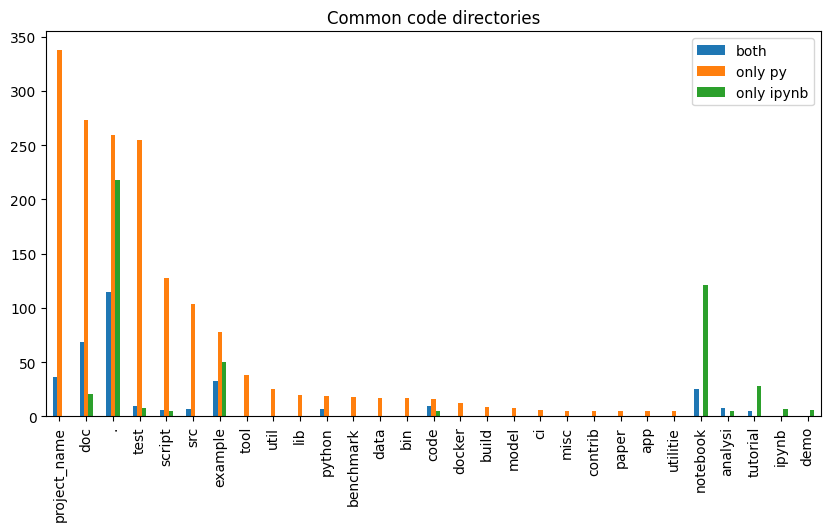

In [ ]:

common_dirs = pd.concat({"both": both, "only py": only_py, "only ipynb": only_ipynb}, axis=1)
common_dirs.sort_values("only py", ascending=False, inplace=True)
common_dirs.plot.bar(figsize=(10,5), title="Common code directories")

#### Do projects have >1 folders with py/ipynb files?

<Axes: >

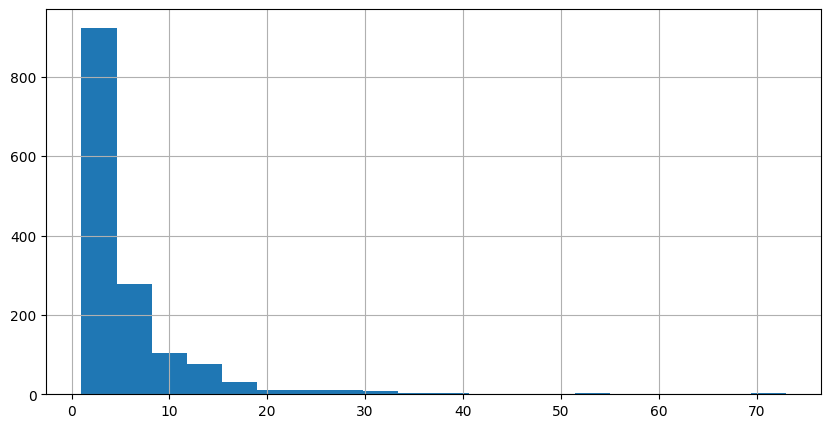

In [ ]:
codedirs_numbers_df =  pd.concat({"both": both_df.sum(axis=1), "only py": only_py_df.sum(axis=1), "only ipynb": only_ipynb_df.sum(axis=1)}, axis=1)
codedirs_numbers_df["sum"] = codedirs_numbers_df.sum(axis=1)
codedirs_numbers_df.sort_values("sum", ascending=False, inplace=True)
codedirs_numbers_df["sum"].hist(bins=20, figsize=(10,5))

## Dependency declaration

In [ ]:
depsfiles = defaultdict(list)
for d in data_z.values():
    if d["project_name"] in python_projects:
        if d["deps_file"]:
            depsfiles[d["project_name"]] = d["deps_file"]
        else:
            depsfiles[d["project_name"]] = {}


    # "deps_file": [
    #     {
    #         "source_type": "DepsSource",
    #         "path": "setup.py",
    #         "parser_choice": "setup.py",
    #         "deps_count": 0,
    #         "warnings": true
    #     },
# df_depsfiles = pd.DataFrame.from_dict(depsfiles, orient="index")
print({dd.get("source_type") for d in depsfiles.values() for dd in d})
print({dd.get("parser_choice") for d in depsfiles.values() for dd in d})



{'DepsSource'}
{'requirements.txt', 'pyproject.toml', 'setup.py', 'setup.cfg'}


In [ ]:

threshold = 0

parser_choice = [len({entry["parser_choice"] for entry in v if entry["deps_count"]>threshold})  for _, v in depsfiles.items() if v]

print(len(depsfiles), 
 len(parser_choice), 
 len([v for v in parser_choice if v > 1]), 
 len([v for v in parser_choice if v > 2]), 
 len([v for v in parser_choice if v > 3]))


1113 677 163 3 0


In [ ]:
# Sanity check - consistency between parser choice and names
from collections import Counter
parsed_files = defaultdict(list)
for k, v in depsfiles.items():
    for entry in v:
       if entry["deps_count"]>0:
           parsed_files[entry["parser_choice"]].append(entry["path"].split("/")[-1])


{k: Counter(v) for k, v in parsed_files.items()}


{'requirements.txt': Counter({'requirements.txt': 511,
          'dev-requirements.txt': 38,
          'test-requirements.txt': 26,
          'requirements_pip.txt': 24,
          'requirements-dev.txt': 22,
          'pinned-requirements.txt': 9,
          'requirements_conda.txt': 9,
          'conda_requirements.txt': 6,
          'requirements_dev.txt': 6,
          'requirements.in': 5,
          'doc-requirements.txt': 5,
          'test_requirements.txt': 5,
          'doc_requirements.txt': 5,
          'pip_requirements.txt': 4,
          'requirements_docs.txt': 4,
          'requirements_for_rdt.txt': 3,
          'rtd-requirements.txt': 3,
          'requirements_test.txt': 3,
          'docs-requirements.txt': 3,
          'driver_requirements.txt': 3,
          'lint-requirements.txt': 3,
          'requirements-doc.txt': 3,
          'requirements.dev.txt': 2,
          'requirements_doc.txt': 2,
          'rtd_requirements.txt': 2,
          'readthedocs_requirements.tx

In [ ]:
# Sanity check - what % of setup.py files emit warnings?

warnings_setup_files = [(entry["warnings"], entry["deps_count"]) for k, v in depsfiles.items() for entry in v if entry["parser_choice"] == "setup.py"]

print("Just warnings: ", len(warnings_setup_files), sum([i for i, _ in warnings_setup_files]),
      sum([i for i,_ in warnings_setup_files])/len(warnings_setup_files))

print("Warnings, but dependencies found: ", len(warnings_setup_files), sum([i for i, j in warnings_setup_files if j>0]),
      sum([i for i,j in warnings_setup_files if j>0])/sum([i for i,_ in warnings_setup_files]))


print("Warnings with found deps compared to allfound deps: ", len([i for i,j in warnings_setup_files if j>0]), sum([i for i, j in warnings_setup_files if j>0]),
      sum([i for i,j in warnings_setup_files if j>0])/len([i for i,j in warnings_setup_files if j>0]))


Just warnings:  576 320 0.5555555555555556
Warnings, but dependencies found:  576 145 0.453125
Warnings with found deps compared to allfound deps:  278 145 0.5215827338129496


It looks like half of the setup.py files are not used to declare dependencies.

### Check if existence of dependency declaration is somehow correlated with the project structure.


Declared deps percent: 61.0
Undeclared deps percent: 39.0

 only_ipynb_df


,no_deps,declared_deps,all,% all - no_deps
notebook,57,55,112,50.9
tutorial,3,22,25,12.0
doc,5,13,18,27.8
binder,1,5,6,16.7
ipynb,2,4,6,33.3



 only_py_df


,no_deps,declared_deps,all,% all - no_deps
project_name,11,288,299,3.7
doc,16,232,248,6.5
script,52,64,116,44.8
src,31,66,97,32.0
tool,2,32,34,5.9



 both_df


,no_deps,declared_deps,all,% all - no_deps
doc,0,53,53,0.0
project_name,2,28,30,6.7
notebook,11,11,22,50.0
code,9,2,11,81.8
analysi,8,1,9,88.9



 total


,no_deps,declared_deps,all,% all - no_deps
project_name,13,316,329,4.0
doc,21,298,319,6.6
notebook,68,67,135,50.4
script,57,68,125,45.6
src,35,68,103,34.0


<Axes: title={'center': '% of projects with undeclared deps'}>

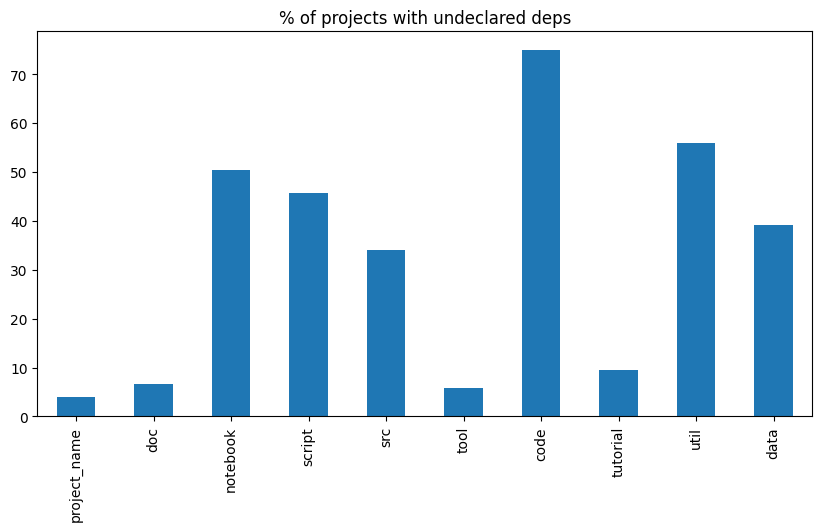

In [ ]:
projects_without_deps = [k for k, v in depsfiles.items() if not v]
projects_with_deps = [k for k, v in depsfiles.items() if v]

dfs = {'only_ipynb_df': only_ipynb_df, 'only_py_df': only_py_df, 'both_df': both_df,
       'total': only_ipynb_df.add(only_py_df, fill_value=0).add(both_df, fill_value=0) }

print("Declared deps percent:", np.round(len(projects_with_deps) / len(depsfiles) * 100))
print("Undeclared deps percent:", np.round(len(projects_without_deps) / len(depsfiles) * 100))

declared_deps_split = {}
for name, df in dfs.items():
    print("\n", name)
    res1 = group_codedirs(df.loc[projects_without_deps,:], threshold=0)
    res2 = group_codedirs(df.loc[projects_with_deps,:], threshold=0)
    res3 = group_codedirs(df, threshold=0)
    declared_deps_split[name] = pd.concat({"no_deps": res1, "declared_deps": res2, "all": res3}, axis=1)
    declared_deps_split[name]["% all - no_deps"] = np.round(declared_deps_split[name]["no_deps"] / declared_deps_split[name]["all"], 3) * 100   
    display(declared_deps_split[name].sort_values("all", ascending=False).head())
    declared_deps_split[name].fillna(0, inplace=True)

declared_deps_split["total"][["% all - no_deps", "all"]].sort_values("all", ascending=False).head(10)["% all - no_deps"].plot.bar(figsize=(10,5), title="% of projects with undeclared deps")